In [78]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np
from skimage.external.tifffile import imread
from skimage import io
import os
from os.path import join as oj
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate, train_test_split
import data
import numpy as np
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F
import torch
from skorch import NeuralNetClassifier
from skorch import NeuralNetRegressor

X, Y = data.get_data()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# look at data

/system/linux/anaconda3.7/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


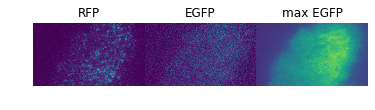

In [9]:
R, C = 1, 3
plt.figure(figsize=(C*2, R*2))

plt.subplot(R, C, 1)
plt.title('RFP')
plt.imshow(X[0])

plt.subplot(R, C, 2)
plt.title('EGFP')
plt.imshow(Y[0])

plt.subplot(R, C, 3)
plt.title('max EGFP')
plt.imshow(Y.sum(axis=0))
plt.subplots_adjust(hspace=0.1, wspace=0)

for i in range(1, 4):
    plt.subplot(R, C, i)
    plt.axis('off')

In [10]:
X.shape

(300, 255, 450)

# linear model

In [15]:
X_patches, Y_centers = data.extract_patch_features(X, Y)

In [16]:
X_patches.shape

(109174, 9, 9, 300)

In [17]:
Y_centers.shape

(109174,)

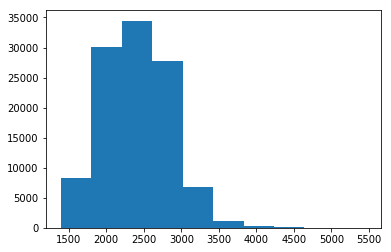

In [18]:
plt.hist(Y_centers)
plt.show()

In [61]:
n = 100
X_flat = X_patches[:n].reshape(n, -1)
Y_flat = Y_centers[:n]
# m = LinearRegression()
m = RidgeCV(store_cv_values=True)
m_fit = m.fit(X_flat, Y_flat)

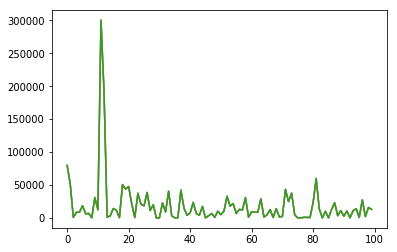

In [43]:
plt.plot(m_fit.cv_values_)

In [ ]:
plt.plot(m.coef_)

In [46]:
print('score', m.score(X_flat, Y_flat))

score 0.9999999999999848


# multi-linear model

In [57]:
X.shape

(100, 24300)

In [85]:
class MyModule(nn.Module):
    def __init__(self, num_units=2, nonlin=F.relu):
        super(MyModule, self).__init__()

        self.fc1 = nn.Linear(24300, num_units)

    def forward(self, X, **kwargs):
        X = self.fc1(X).max()
        return X


net = NeuralNetRegressor(
    MyModule,
    max_epochs=100,
    lr=1e-5,
    iterator_train__shuffle=True,
    optimizer=torch.optim.Adam,
)

X = X_flat.astype(np.float32)
Y = Y_flat.reshape(-1, 1).astype(np.float32)
# X, y = make_classification(1000, 20, n_informative=10, random_state=0)
# X = X.astype(np.float32)
# y = y.astype(np.int64)

net.fit(X, Y)
yhat = net.predict(X)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1  2704284.0000  2196918.0000  0.0096
      2  1945992.6250  1533632.3750  0.0049
      3  1317261.6250   999066.5000  0.0049
      4   818586.9375   591365.1875  0.0048
      5   447648.6875   304971.0625  0.0048
      6   198219.4531   129480.1016  0.0048
      7    59024.6406    48872.9531  0.0048
      8    12975.0059    41678.9883  0.0047
      9    37398.7969    82664.5547  0.0048
     10   105869.3359   146065.4531  0.0048
     11   191615.2969   209463.3906  0.0048
     12   271570.4062   256838.1562  0.0048
     13   329491.5938   279782.8438  0.0049
     14   357161.9375   276847.6250  0.0048
     15   353633.8750   251785.0312  0.0048
     16   323368.5938   211467.3750  0.0048
     17   274045.9375   164029.1250  0.0095
     18   214649.6875   117379.7734  0.0079
     19   153924.0156    78154.2734  0.0049
     20    99301.7500    51015.2148  0.0048
     21    56195.7656    38297.1

ValueError: zero-dimensional arrays cannot be concatenated